# UPDATED VERSION IN PYCHARM PROJECTS 

In [1]:
import requests
import pandas as pd
import json 
from datetime import datetime, timedelta
from time import time
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
'''Remove this - in favour off a state/json'''

# class stock:
#     symbol = None
#     value = None
#     purchaseDate = None 
#     valuePurchaseDate = None
#     n_count = None

'Remove this - in favour off a state/json'

In [3]:
class Requester:
    def __init__(self):
        self.IP = "127.0.0.1"
        self.PORT = 5001
        self.IP_predictor = "127.0.0.1"
        self.PORT_predictor = 5002

    def get_symbols(self):
        url = "http://{}:{}/getDistinct".format(self.IP, self.PORT)
        response = requests.get(url)
        df = pd.read_json(response.text)
        return df.symbol.values.tolist()

    def get_stock(self, ticker, date=None, n_to_request=25):
        logging.info("Get stock: {},\t{}\t{}".format(ticker, date, n_to_request))
        if date:
            url = "http://{}:{}/getStockAtDate/{}/{}/{}".format(self.IP, self.PORT, ticker, date, n_to_request)
        else:
            url = "http://{}:{}/getStock/{}/{}".format(self.IP, self.PORT, ticker, n_to_request)
        response = requests.get(url)
        df = pd.read_json(response.text)
        return df.sort_values(by='date')

    def get_stock_as_json(self, ticker, date=None):
        try:
            ret = self.get_stock(ticker, date)
            json_stock = ret.to_dict(orient='index')[0]
            if json_stock["date"].strftime("%Y-%m-%d") == date:
                return json_stock
            else:
                return dict({'date': date, 
                         'nearest date': json_stock['date'],
                         'error': 'invalid-date'})
        except Exception as e:          
                logging.error(e)
                return dict({'error': e})
            
    def _predict_stock(self, df):
        url = "http://{}:{}/invocations".format(self.IP_predictor, self.PORT_predictor)
        headers = {
            'Content-Type': 'application/json; format=pandas-split',
        }
        try:
            response = requests.post(url, headers=headers, data=df.to_json(orient='split'))
            latest_date_pred = json.loads(response.text)[-1] # Return last (latest day from input) - [0, 1] = (0) sell, (1) buy.        
            return latest_date_pred
        except Exception as e:
#             logging.error(e, response.text)
            return [0,0]
    
    def predict_stock(self, ticker, date=None):
        logging.info("predicting: ".format(ticker))
        df = self.get_stock(ticker, date)
        return self._predict_stock(df)

In [7]:
class Portfolio:
    _id = None
    name = None
    holdings = None
    cash = None
    date = None
    r = Requester()

    def __init__(self, name, _id=None):
        self.name = name
        self.holdings = {}
        if _id:
            self._id = _id
        else:
            self._id = time()
        logger.info(self._id)
    
    def save(self):
        pass
    
    def load(self):
        pass
    
    def update(self, date=None):
        self.load()
        self.update_holdings()
        logging.info("cash".format(self.cash))
        for symbol in self.r.get_symbols()[:20]:
            logger.info(self.date)
            stock = self.r.get_stock_as_json(symbol, self.date)
            logging.info(stock)
            if 'error' not in stock.keys():
                decision = self.r.predict_stock(symbol, self.date)
                logging.info("{}, {}".format(decision, str(decision[1])))
                if decision[1]>.5:
                    self._buy(stock)
                else:
                    self._sell(symbol)
        logging.info("cash: {}".format(self.cash))
        self.save()
        
    def update_holdings(self):
        logging.info(self.holdings.keys())
        for symbol in self.holdings.keys():
            stock = self.r.get_stock_as_json(symbol, self.date)
            if 'error' not in stock.keys():
                self.holdings[symbol] = stock

    def _buy(self, stock, volume=None):
        symbol = stock['symbol']
        if self.cash < stock['adjusted_close']:
            logging.info("Can't buy - not enough money, cash:{}, symbol:{}, value: {}".format(self.cash, symbol, stock['adjusted_close']))
            return None
        if symbol not in self.holdings.keys():
            self.holdings[symbol] = stock
            self.cash -= stock['adjusted_close']
            logging.info("Bought: {}, value: {}".format(symbol, stock['adjusted_close']))
        return True
    
    def _sell(self, symbol=None, volume=None):
        if symbol in self.holdings.keys():
            stock = self.holdings[symbol]
            logging.info(stock['date'], stock['date'].strftime("%Y-%m-%d"), self.date)
            assert stock['date'].strftime("%Y-%m-%d") == self.date
            self.cash += stock['adjusted_close']
            self.holdings.pop(symbol)
            logging.info("Sold", symbol, "value:", stock['adjusted_close'], "cash:", self.cash)
    
    def get_value(self):
        holdings_value = sum([stock['adjusted_close'] for stock in self.holdings.values()])  
        return holdings_value + self.cash
    
    def get_holdings(self):
        pass
    
    def set_date(self, date=None):
        if date:
            self.date = date
        else:
            self.date = datetime.now().strftime("%Y-%m-%d")

In [10]:
### TEST

logger.setLevel(logging.DEBUG)

r = Requester()
assert len(r.get_symbols()) > 3
r.get_stock("MSFT", n_to_request=2)
r.get_stock("MSFT", date="2019-02-02")
assert "close" in r.get_stock("AMZN").columns
logging.info(r.predict_stock("MMM"))
logging.info(r.predict_stock("MMM", "2017-02-02"))

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 127.0.0.1:5001
DEBUG:urllib3.connectionpool:http://127.0.0.1:5001 "GET /getDistinct HTTP/1.1" 200 6028
INFO:root:Get stock: MSFT,	None	2
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 127.0.0.1:5001
DEBUG:urllib3.connectionpool:http://127.0.0.1:5001 "GET /getStock/MSFT/2 HTTP/1.1" 200 402
INFO:root:Get stock: MSFT,	2019-02-02	25
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 127.0.0.1:5001
DEBUG:urllib3.connectionpool:http://127.0.0.1:5001 "GET /getStockAtDate/MSFT/2019-02-02/25 HTTP/1.1" 200 3659
INFO:root:Get stock: AMZN,	None	25
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 127.0.0.1:5001
DEBUG:urllib3.connectionpool:http://127.0.0.1:5001 "GET /getStock/AMZN/25 HTTP/1.1" 200 3733
INFO:root:predicting: 
INFO:root:Get stock: MMM,	None	25
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 127.0.0.1:5001
DEBUG:urllib3.connectionpool:http://127.0.0.1:5001 "GET /getS

In [15]:
%%time

# from tqdm import tqdm_notebook as tqdm

class Simulation:
    def __init__(self):
        self.portfolio = None
        self.hist = []
    
    def run(self, start, stop):
        p = Portfolio("testada")
        self.portfolio = p
        p.cash = 1000
        logging.info(p.holdings.keys())
        for date in self._get_date_between(start, stop):
            print(date)
            p.set_date(date)
            p.update()
            logging.info("PORTFOLIO VALUE: {}".format(p.get_value()))
            self.hist.append(p.get_value())
            
    def _get_date_between(self, start, stop):
        startd = datetime.strptime(start, "%Y-%m-%d").date()
        stopd = datetime.strptime(stop, "%Y-%m-%d").date()
        delta = stopd - startd
        return [(startd + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(delta.days + 1)]
    
    
logger.setLevel(logging.INFO)

s = Simulation()
s.run("2018-01-02", "2019-01-04")

INFO:root:1570971745.7802331
INFO:root:dict_keys([])
INFO:root:dict_keys([])
INFO:root:cash


2018-01-02


INFO:root:2018-01-02
INFO:root:Get stock: MSFT,	2018-01-02	25
INFO:root:{'close': 85.95, 'open': 86.125, 'symbol': 'MSFT', 'adjusted_close': 83.8177, 'low': 85.5, 'date': Timestamp('2018-01-02 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 21993101, 'id': 'MSFT2018-01-02', 'high': 86.31}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-02	25
INFO:root:[0.4999234765036574, 0.5000765234963427], 0.5000765234963427
INFO:root:Bought: MSFT, value: 83.8177
INFO:root:2018-01-02
INFO:root:Get stock: SPX,	2018-01-02	25
INFO:root:{'close': 2695.8101, 'open': 2683.73, 'symbol': 'SPX', 'adjusted_close': 2695.8101, 'low': 2682.3601, 'date': Timestamp('2018-01-02 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 3367250000, 'id': 'SPX2018-01-02', 'high': 2695.8899}
INFO:root:predicting: 
INFO:root:Get stock: SPX,	2018-01-02	25
INFO:root:[0.4986028909404828, 0.5013971090595172], 0.5013971090595172
INFO:root:Can't buy - not enough money, cash:916.18229999

2018-01-03


INFO:root:Get stock: CF,	2018-01-03	25
INFO:root:Get stock: CTL,	2018-01-03	25
INFO:root:Get stock: SCHW,	2018-01-03	25
INFO:root:Get stock: AMD,	2018-01-03	25
INFO:root:Get stock: CNC,	2018-01-03	25
INFO:root:Get stock: CERN,	2018-01-03	25
INFO:root:Get stock: CTAS,	2018-01-03	25
INFO:root:Get stock: CHD,	2018-01-03	25
INFO:root:Get stock: CMG,	2018-01-03	25
INFO:root:Get stock: CSCO,	2018-01-03	25
INFO:root:Get stock: AAP,	2018-01-03	25
INFO:root:cash
INFO:root:2018-01-03
INFO:root:Get stock: MSFT,	2018-01-03	25
INFO:root:{'close': 86.35, 'open': 86.055, 'symbol': 'MSFT', 'adjusted_close': 84.2077, 'low': 85.97, 'date': Timestamp('2018-01-03 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 24173064, 'id': 'MSFT2018-01-03', 'high': 86.51}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-03	25
INFO:root:[0.49929266993596244, 0.5007073300640376], 0.5007073300640376
INFO:root:Can't buy - not enough money, cash:39.55109999999993, symbol:MSFT, value: 84.2077
INF

2018-01-04


INFO:root:Get stock: CF,	2018-01-04	25
INFO:root:Get stock: CINF,	2018-01-04	25
INFO:root:Get stock: CTL,	2018-01-04	25
INFO:root:Get stock: SCHW,	2018-01-04	25
INFO:root:Get stock: AMD,	2018-01-04	25
INFO:root:Get stock: CNC,	2018-01-04	25
INFO:root:Get stock: CTAS,	2018-01-04	25
INFO:root:Get stock: CHD,	2018-01-04	25
INFO:root:Get stock: CNP,	2018-01-04	25
INFO:root:Get stock: CMG,	2018-01-04	25
INFO:root:Get stock: CSCO,	2018-01-04	25
INFO:root:Get stock: AAP,	2018-01-04	25
INFO:root:cash
INFO:root:2018-01-04
INFO:root:Get stock: MSFT,	2018-01-04	25
INFO:root:{'close': 87.11, 'open': 86.59, 'symbol': 'MSFT', 'adjusted_close': 84.9489, 'low': 86.57, 'date': Timestamp('2018-01-04 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 21145985, 'id': 'MSFT2018-01-04', 'high': 87.66}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-04	25
INFO:root:[0.5000333213072532, 0.49996667869274686], 0.49996667869274686
--- Logging error ---
Traceback (most recent call last)

2018-01-05


INFO:root:Get stock: CVX,	2018-01-05	25
INFO:root:Get stock: CHD,	2018-01-05	25
INFO:root:Get stock: CSCO,	2018-01-05	25
INFO:root:Get stock: AAP,	2018-01-05	25
INFO:root:cash
INFO:root:2018-01-05
INFO:root:Get stock: MSFT,	2018-01-05	25
INFO:root:{'close': 88.19, 'open': 87.66, 'symbol': 'MSFT', 'adjusted_close': 86.0021, 'low': 87.43, 'date': Timestamp('2018-01-05 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 22526563, 'id': 'MSFT2018-01-05', 'high': 88.41}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-05	25
INFO:root:[0.49930479899743374, 0.5006952010025663], 0.5006952010025663
INFO:root:Bought: MSFT, value: 86.0021
INFO:root:2018-01-05
INFO:root:Get stock: SPX,	2018-01-05	25
INFO:root:{'close': 2743.1499, 'open': 2731.3301, 'symbol': 'SPX', 'adjusted_close': 2743.1499, 'low': 2727.9199, 'date': Timestamp('2018-01-05 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 3236620000, 'id': 'SPX2018-01-05', 'high': 2743.45}
INFO:root:pred

2018-01-06


INFO:root:Get stock: CTL,	2018-01-06	25
INFO:root:Get stock: SCHW,	2018-01-06	25
INFO:root:Get stock: CVX,	2018-01-06	25
INFO:root:Get stock: CNC,	2018-01-06	25
INFO:root:Get stock: CHTR,	2018-01-06	25
INFO:root:Get stock: CSCO,	2018-01-06	25
INFO:root:Get stock: AAP,	2018-01-06	25
INFO:root:cash
INFO:root:2018-01-06
INFO:root:Get stock: MSFT,	2018-01-06	25
INFO:root:{'date': '2018-01-06', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-06
INFO:root:Get stock: SPX,	2018-01-06	25
INFO:root:{'date': '2018-01-06', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-06
INFO:root:Get stock: AMD,	2018-01-06	25
INFO:root:{'date': '2018-01-06', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-06
INFO:root:Get stock: CNC,	2018-01-06	25
INFO:root:{'date': '2018-01-06', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-06
INFO

2018-01-07


INFO:root:Get stock: CTL,	2018-01-07	25
INFO:root:Get stock: SCHW,	2018-01-07	25
INFO:root:Get stock: CVX,	2018-01-07	25
INFO:root:Get stock: CNC,	2018-01-07	25
INFO:root:Get stock: CHTR,	2018-01-07	25
INFO:root:Get stock: CSCO,	2018-01-07	25
INFO:root:Get stock: AAP,	2018-01-07	25
INFO:root:cash
INFO:root:2018-01-07
INFO:root:Get stock: MSFT,	2018-01-07	25
INFO:root:{'date': '2018-01-07', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-07
INFO:root:Get stock: SPX,	2018-01-07	25
INFO:root:{'date': '2018-01-07', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-07
INFO:root:Get stock: AMD,	2018-01-07	25
INFO:root:{'date': '2018-01-07', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-07
INFO:root:Get stock: CNC,	2018-01-07	25
INFO:root:{'date': '2018-01-07', 'nearest date': Timestamp('2018-01-05 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-07
INFO

2018-01-08


INFO:root:Get stock: CTL,	2018-01-08	25
INFO:root:Get stock: SCHW,	2018-01-08	25
INFO:root:Get stock: CVX,	2018-01-08	25
INFO:root:Get stock: CNC,	2018-01-08	25
INFO:root:Get stock: CHTR,	2018-01-08	25
INFO:root:Get stock: CSCO,	2018-01-08	25
INFO:root:Get stock: AAP,	2018-01-08	25
INFO:root:cash
INFO:root:2018-01-08
INFO:root:Get stock: MSFT,	2018-01-08	25
INFO:root:{'close': 88.28, 'open': 88.2, 'symbol': 'MSFT', 'adjusted_close': 86.0899, 'low': 87.6046, 'date': Timestamp('2018-01-08 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 20293930, 'id': 'MSFT2018-01-08', 'high': 88.58}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-08	25
INFO:root:[0.49933602190541276, 0.5006639780945873], 0.5006639780945873
INFO:root:2018-01-08
INFO:root:Get stock: SPX,	2018-01-08	25
INFO:root:{'close': 2747.71, 'open': 2742.6699, 'symbol': 'SPX', 'adjusted_close': 2747.71, 'low': 2737.6001, 'date': Timestamp('2018-01-08 00:00:00'), 'dividend_amount': 0, 'split_coefficient':

2018-01-09


INFO:root:Get stock: MSFT,	2018-01-09	25
INFO:root:Get stock: CF,	2018-01-09	25
INFO:root:Get stock: CVX,	2018-01-09	25
INFO:root:Get stock: CNC,	2018-01-09	25
INFO:root:Get stock: CHTR,	2018-01-09	25
INFO:root:Get stock: CHD,	2018-01-09	25
INFO:root:cash
INFO:root:2018-01-09
INFO:root:Get stock: MSFT,	2018-01-09	25
INFO:root:{'close': 88.22, 'open': 88.65, 'symbol': 'MSFT', 'adjusted_close': 86.0314, 'low': 87.86, 'date': Timestamp('2018-01-09 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 19390427, 'id': 'MSFT2018-01-09', 'high': 88.7272}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-09	25
INFO:root:[0.5006859755672795, 0.4993140244327206], 0.4993140244327206
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.

2018-01-10


INFO:root:Get stock: CHD,	2018-01-10	25
INFO:root:cash
INFO:root:2018-01-10
INFO:root:Get stock: MSFT,	2018-01-10	25
INFO:root:{'close': 87.82, 'open': 87.86, 'symbol': 'MSFT', 'adjusted_close': 85.6413, 'low': 87.41, 'date': Timestamp('2018-01-10 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 18129153, 'id': 'MSFT2018-01-10', 'high': 88.19}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-10	25
INFO:root:[0.49970512533746175, 0.5002948746625384], 0.5002948746625384
INFO:root:Bought: MSFT, value: 85.6413
INFO:root:2018-01-10
INFO:root:Get stock: SPX,	2018-01-10	25
INFO:root:{'close': 2748.23, 'open': 2745.55, 'symbol': 'SPX', 'adjusted_close': 2748.23, 'low': 2736.0601, 'date': Timestamp('2018-01-10 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 3576350000, 'id': 'SPX2018-01-10', 'high': 2750.8}
INFO:root:predicting: 
INFO:root:Get stock: SPX,	2018-01-10	25
INFO:root:[0.5007142867778774, 0.4992857132221225], 0.4992857132221225
INFO:roo

2018-01-11


INFO:root:Get stock: CF,	2018-01-11	25
INFO:root:Get stock: CI,	2018-01-11	25
INFO:root:Get stock: CTL,	2018-01-11	25
INFO:root:Get stock: CNC,	2018-01-11	25
INFO:root:Get stock: CSCO,	2018-01-11	25
INFO:root:Get stock: AAP,	2018-01-11	25
INFO:root:cash
INFO:root:2018-01-11
INFO:root:Get stock: MSFT,	2018-01-11	25
INFO:root:{'close': 88.08, 'open': 88.13, 'symbol': 'MSFT', 'adjusted_close': 85.8948, 'low': 87.24, 'date': Timestamp('2018-01-11 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 16529868, 'id': 'MSFT2018-01-11', 'high': 88.13}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-11	25
INFO:root:[0.4989232050994184, 0.5010767949005815], 0.5010767949005815
INFO:root:2018-01-11
INFO:root:Get stock: SPX,	2018-01-11	25
INFO:root:{'close': 2767.5601, 'open': 2752.97, 'symbol': 'SPX', 'adjusted_close': 2767.5601, 'low': 2752.78, 'date': Timestamp('2018-01-11 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 3641320000, 'id': 'SPX2018-01-11

2018-01-12


INFO:root:Get stock: CF,	2018-01-12	25
INFO:root:Get stock: CTL,	2018-01-12	25
INFO:root:Get stock: XEC,	2018-01-12	25
INFO:root:Get stock: CHTR,	2018-01-12	25
INFO:root:Get stock: CTAS,	2018-01-12	25
INFO:root:Get stock: CHD,	2018-01-12	25
INFO:root:cash
INFO:root:2018-01-12
INFO:root:Get stock: MSFT,	2018-01-12	25
INFO:root:{'close': 89.6, 'open': 88.67, 'symbol': 'MSFT', 'adjusted_close': 87.3771, 'low': 88.45, 'date': Timestamp('2018-01-12 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 24000439, 'id': 'MSFT2018-01-12', 'high': 89.78}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-12	25
INFO:root:[0.5007142867778774, 0.4992857132221225], 0.4992857132221225
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py"

2018-01-13


INFO:root:Get stock: CTL,	2018-01-13	25
INFO:root:cash
INFO:root:2018-01-13
INFO:root:Get stock: MSFT,	2018-01-13	25
INFO:root:{'date': '2018-01-13', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-13
INFO:root:Get stock: SPX,	2018-01-13	25
INFO:root:{'date': '2018-01-13', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-13
INFO:root:Get stock: AMD,	2018-01-13	25
INFO:root:{'date': '2018-01-13', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-13
INFO:root:Get stock: CNC,	2018-01-13	25
INFO:root:{'date': '2018-01-13', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-13
INFO:root:Get stock: CNP,	2018-01-13	25
INFO:root:{'date': '2018-01-13', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-13
INFO:root:Get stock: CTL,	2018-01-13	25
INFO:root:{'date': '2018-01-13', 'near

2018-01-14


INFO:root:Get stock: CTL,	2018-01-14	25
INFO:root:cash
INFO:root:2018-01-14
INFO:root:Get stock: MSFT,	2018-01-14	25
INFO:root:{'date': '2018-01-14', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-14
INFO:root:Get stock: SPX,	2018-01-14	25
INFO:root:{'date': '2018-01-14', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-14
INFO:root:Get stock: AMD,	2018-01-14	25
INFO:root:{'date': '2018-01-14', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-14
INFO:root:Get stock: CNC,	2018-01-14	25
INFO:root:{'date': '2018-01-14', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-14
INFO:root:Get stock: CNP,	2018-01-14	25
INFO:root:{'date': '2018-01-14', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-14
INFO:root:Get stock: CTL,	2018-01-14	25
INFO:root:{'date': '2018-01-14', 'near

2018-01-15


INFO:root:Get stock: CTL,	2018-01-15	25
INFO:root:cash
INFO:root:2018-01-15
INFO:root:Get stock: MSFT,	2018-01-15	25
INFO:root:{'date': '2018-01-15', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-15
INFO:root:Get stock: SPX,	2018-01-15	25
INFO:root:{'date': '2018-01-15', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-15
INFO:root:Get stock: AMD,	2018-01-15	25
INFO:root:{'date': '2018-01-15', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-15
INFO:root:Get stock: CNC,	2018-01-15	25
INFO:root:{'date': '2018-01-15', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-15
INFO:root:Get stock: CNP,	2018-01-15	25
INFO:root:{'date': '2018-01-15', 'nearest date': Timestamp('2018-01-12 00:00:00'), 'error': 'invalid-date'}
INFO:root:2018-01-15
INFO:root:Get stock: CTL,	2018-01-15	25
INFO:root:{'date': '2018-01-15', 'near

2018-01-16


INFO:root:Get stock: CTL,	2018-01-16	25
INFO:root:cash
INFO:root:2018-01-16
INFO:root:Get stock: MSFT,	2018-01-16	25
INFO:root:{'close': 88.35, 'open': 90.1, 'symbol': 'MSFT', 'adjusted_close': 86.1581, 'low': 88.0104, 'date': Timestamp('2018-01-16 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 35945428, 'id': 'MSFT2018-01-16', 'high': 90.79}
INFO:root:predicting: 
INFO:root:Get stock: MSFT,	2018-01-16	25
INFO:root:[0.5015587919531974, 0.49844120804680253], 0.49844120804680253
INFO:root:2018-01-16
INFO:root:Get stock: SPX,	2018-01-16	25
INFO:root:{'close': 2776.4199, 'open': 2798.96, 'symbol': 'SPX', 'adjusted_close': 2776.4199, 'low': 2768.6399, 'date': Timestamp('2018-01-16 00:00:00'), 'dividend_amount': 0, 'split_coefficient': 1, 'volume': 4325970000, 'id': 'SPX2018-01-16', 'high': 2807.54}
INFO:root:predicting: 
INFO:root:Get stock: SPX,	2018-01-16	25
INFO:root:[0.5015587919531974, 0.49844120804680253], 0.49844120804680253
INFO:root:2018-01-16
INFO:root:Get sto

KeyboardInterrupt: 

In [39]:
def _get_yesterday(current_date):
    d = datetime.strptime(current_date, "%Y-%m-%d").date()
    return datetime.strftime(d - timedelta(1), '%Y-%m-%d')
_get_yesterday("2019-02-01")

'2019-01-31'

In [30]:
# %%time
s.portfolio.get_value()

1012.6171000000002

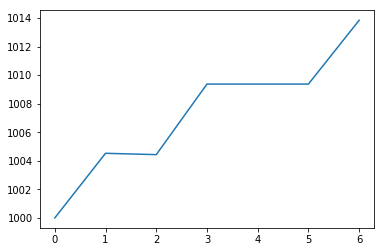

In [31]:
import matplotlib.pyplot as plt
plt.plot(s.hist)
plt.show()